In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
import datetime

# Project, a deeper dive into the math behind fitting model parameters.

Recall that in weeks 5 and 6 we explored fitting model parameters, and in particular, fitting data on the excess counts from Vela using a model with two parameters, a slope and an offset.

It this project we are going to explore the math behind the fitting a bit more.  In particular we are going to simplify the model a bit by removing the slope, so that we are only fitting for the offset.   

This model is simple enough that we can take the derivatives by hand, and we can solve for the minimum. 

Some things you might do:

Recall that the $\chi^2$ is given by:

$\chi^2 = \sum_i (\frac{n_i - m_i(x)}{\sigma_i})^2$

Where $n_i$ is the number of counts from week $i$ (i.e., 'excess_counts' in the next cell) and $\sigma_i$ is uncertainty on that number (i.e., 'sigma_counts' in the next cell).

And in our case our model is trivial:

$m(x) = p_0$, leaving use with

$\chi^2 = \sum_i (\frac{n_i - p_0}{\sigma_i})^2$


Some goals for this project could include:

1. Take the first and second partial derivativs of the $\chi^2$ with respect to $p_0$.   If you aren't sure how to take a derivative of an expression inside a sum you can try just writing out the first three terms of the sum and taking the derivatives of those:

$\chi^2 = (\frac{n_0 - p_0}{\sigma_i})^2 + (\frac{n_i - p_0}{\sigma_i})^2 + (\frac{n_2 - p_0}{\sigma_i})^2 + ...$

2. Write out your own expression of the first and second derivatives of $\chi^2$ with respect to $p_0$.  Implement them as functions, plot them and verify your results by comparing them to the functions that we wrote that date the derivatives numerically.

3. Then you can explicitly solve for best fit value of $p_0$ by solving for the place where the first derivative is zero.  This will give you an expressing for $p_0$ in terms of the $n_i$ and $\sigma_i$.

4. You can explicitly solve for uncertainty on $p_0$ ($\sigma_{p0}$) by noting that they correspond to the points where the $\chi^2$ function changes by 1 with respect to the minimum, and also by noting that the $\chi^2$ function is a parabola, you can also write as $\Delta \chi^2 = a (\delta p_0)^2$.  (For this step you can either demonstrate that for our case $a = \frac{1}{2} \frac{\partial^2\chi^2}{\partial p_0^2}$ or you can just take our word on that.)

6. Finally, you can compare the formulas you got for $p_0$ and $\sigma_{p0}$ to the formulas for taking the weighted average by inverse variance weighting. 


In [2]:
data = np.loadtxt(open("../data/Vela_Flux.txt", 'rb'), usecols=range(7))

# This is how we pull out the data from columns in the array.

# This is the date in "Mission Elapsesd Time"
# For the Fermi mission, this is defined to be the number of seconds since the start of 2001.
date_MET = data[:,0]
# This is the offset in seconds between the Fermi "MET" and the UNIX "epoch" used by matplotlib
MET_To_Unix = 978336000

# These are the numbers of photons observed from Vela each week in the "low" Energy Band (100 MeV - 800 MeV)
nObs_LE = data[:,1]

# These are the number of photons expected from Vela each week, under the assumption that it is 
# not varying at all, and the only differences depend on how long we spent looking at Vela
# that particular weeek
nExp_LE = data[:,2]

# These are the band bounds, in MeV
LE_bounds = (100., 800.)

# This is the "significance" of the variation for each week.  We will discuss this more later
signif_LE = data[:,3]

# This converts the dates to something that matplotlib understands
dates = [datetime.datetime.fromtimestamp(date + MET_To_Unix) for date in date_MET]
date_YEAR = 2001 +  (date_MET / (24*3600*365))
years_since_mid_2014 = date_YEAR  - 2014.5

excess_counts = nObs_LE-nExp_LE
sigma_counts =  np.sqrt(nObs_LE)

# Defining the model and the cost function

This next cell defines the model and the cost function

In [3]:
def constant_function(xvals, params):
    return params[0]

def residual_function(data_x, data_y, model_function, params):
    model_y = model_function(data_x, params)
    residual = data_y - model_y
    return residual

def chi2_function(data_x, data_y, data_sigma_y, model_function, params):
    model_y = model_function(data_x, params)
    chi2 = ((data_y - model_y)/(data_sigma_y))**2
    return np.sum(chi2)

def cost_function(params):
    return 0.5*chi2_function(years_since_mid_2014, excess_counts, sigma_counts, constant_function, params)

def plot_data(dates, excess_counts, sigma_counts, p0, p0err):
    _ = plt.errorbar(dates, excess_counts, sigma_counts)
    _ = plt.errorbar(dates, np.ones(len(dates))*(p0-p0err), np.ones(len(dates))*(p0+p0err))
    _ = plt.xlabel(r'Date [year]')
    _ = plt.ylabel(r'Counts')

# Fitting the data for p_0, the offset number of counts

This next cell fits the model, prints out the result, and plots both the data and the best fit.

Fitter result:
      fun: 382.2499943497748
 hess_inv: array([[4.3492921]])
      jac: array([3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([-1.68807772])

Human readable version ---------------
  p0 best fit value: -1.7 +- 2.1 counts
  Minimum value of cost function: 382.2
  Minimum value of chi**2: 764.5


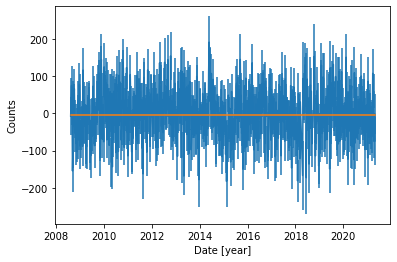

In [4]:
result = optimize.minimize(cost_function, x0=[0.])
pars = result['x']
fmin = result['fun']
p0_best = pars[0]
cov = result['hess_inv']
p0_err = np.sqrt(cov[0,0])

print("Fitter result:")
print(result)

print("")
print("Human readable version ---------------")
print("  p0 best fit value: %.1f +- %.1f counts" % (p0_best, p0_err))
print("  Minimum value of cost function: %.1f" % fmin)
print("  Minimum value of chi**2: %.1f" % (2*fmin))

plot_data(dates, excess_counts, sigma_counts, p0_best, p0_err)

# Numerical derivatives and plots of them

These functions will compute the derivates of the $\chi^2$ with respect to $p_0$ and also make plots of them.

In [5]:
def chi2_scan(cost_func, xvals):
    chi2_vals = np.zeros(xvals.shape)
    for i, xv in enumerate(xvals):
        chi2_vals[i] = 2*cost_func([xv])
    return chi2_vals

def numerical_deriv(cost_func, xvals):
    dx = np.mean(xvals[1:] - xvals[:-1]) / 50.
    chi2_0 = chi2_scan(cost_func, xvals)
    chi2_1 = chi2_scan(cost_func, xvals + dx)
    return (chi2_1 - chi2_0)/dx

def numerical_2nd_deriv(cost_func, xvals):
    dx = np.mean(xvals[1:] - xvals[:-1]) / 50.
    deriv_0 = numerical_deriv(cost_func, xvals)
    deriv_1 = numerical_deriv(cost_func, xvals + dx)
    return (deriv_1 - deriv_0)/dx

def plot_chi2(cost_func, xvals):
    yvals = chi2_scan(cost_function, xvals)
    _ = plt.plot(xvals, yvals)
    _ = plt.xlabel(r'$p_0$ [counts]')
    _ = plt.ylabel(r'$\chi^2$')
    
def plot_dchi2_dp0(cost_func, xvals):
    yvals = numerical_deriv(cost_function, xvals)
    _ = plt.plot(xvals, yvals)
    _ = plt.xlabel(r'$p_0$ [counts]')
    _ = plt.ylabel(r'First Derivative: $\frac{\partial\chi^2}{\partial p_0}$')
    
def plot_d2chi2_dp02(cost_func, xvals):
    yvals = numerical_2nd_deriv(cost_function, xvals)
    _ = plt.plot(xvals, yvals)
    _ = plt.xlabel(r'$p_0$ [counts]')
    _ = plt.ylabel(r'Second Derivative: $\frac{\partial^2\chi^2}{\partial p_0^2}$')
    _ = plt.ylim(-1, 1)

# This is the grid we will use for plotting
xvals = np.linspace(-10, 10, 101)

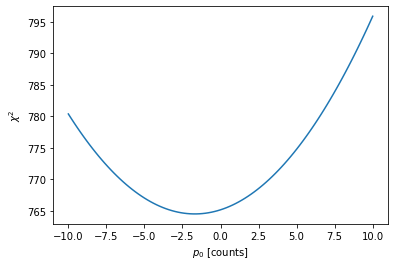

In [6]:
plot_chi2(cost_function, xvals)

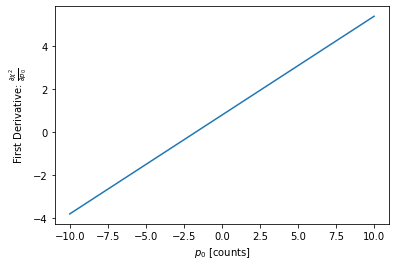

In [7]:
plot_dchi2_dp0(cost_function, xvals)

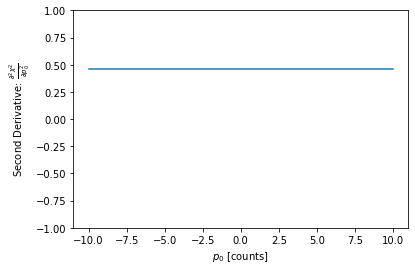

In [8]:
plot_d2chi2_dp02(cost_function, xvals)

# Derivatives of $\chi^2$

## First Derivative

Recall that $\chi^2 = \sum_i \left( \frac{n_i - p_0}{\sigma_i} \right)^2$. Thus, $\frac{d}{dp_0} \chi^2 = \sum_i 2 \left( \frac{n_i - p_0}{\sigma_i} \right) \left( -\frac{1}{\sigma_i} \right) = -2 \sum_i \frac{n_i - p_0}{\sigma_i^2}$.

## Second Derivative

From above, $\frac{d}{dp_0} \chi^2 = -2 \sum_i \frac{n_i - p_0}{\sigma^2}$. Thus, $\frac{d^2}{dp_0^2} = 2 \sum_i \frac{1}{\sigma_i^2}$.

In [10]:
def first_derivative_of_chi_squared(n_values, sigma_values, p_0):
  return -2 * sum((n_values - p_0) / (sigma_values ** 2))

In [18]:
def second_derivative_of_chi_squared(sigma_values):
  return 2 * sum(1 / (sigma_values ** 2))

In [16]:
def plot_first_derivative(n_values, sigma_values, p_0_values):
  first_derivatives = np.empty_like(p_0_values)
  for i in range(len(first_derivatives)):
    first_derivatives[i] = first_derivative_of_chi_squared(n_values, sigma_values, p_0_values[i])
  plt.plot(p_0_values, first_derivatives)
  _ = plt.xlabel(r'$p_0$ [counts]')
  _ = plt.ylabel(r'First Derivative: $\frac{\partial\chi^2}{\partial p_0}$')

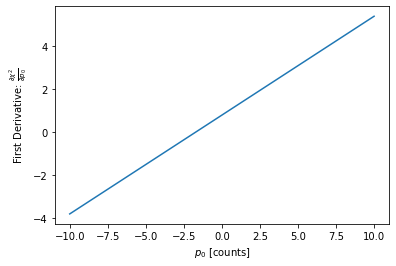

In [17]:
plot_first_derivative(excess_counts, sigma_counts, xvals)

In [26]:
def plot_second_derivative(n_values, sigma_values, p_0_values):
  second_derivative = second_derivative_of_chi_squared(sigma_values)
  second_derivatives = np.full_like(p_0_values, second_derivative)
  plt.plot(p_0_values, second_derivatives)
  _ = plt.xlabel(r'$p_0$ [counts]')
  _ = plt.ylabel(r'Second Derivative: $\frac{\partial^2\chi^2}{\partial p_0^2}$')
  _ = plt.ylim(-1, 1)

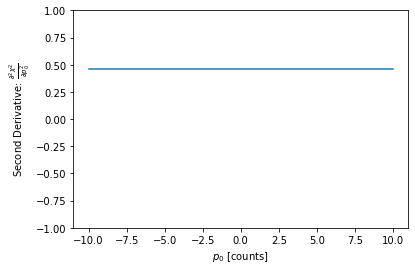

In [27]:
plot_second_derivative(excess_counts, sigma_counts, xvals)

## Discussion

By visual inspection, the plots I came up with by deriving the closed-form expressions for the first- and second-derivatives match the ones produced using numerical methods for derivative computation.

## Optimizing $\chi^2$

$$
\begin{align*}
  \frac{d}{dp_0} \chi^2 &= 0\\
  -2 \sum_i \frac{n_i - p_0}{\sigma_i^2} &= 0\\
  \sum_i \frac{n_i - p_0}{\sigma_i^2} &= 0\\
  \sum_i \frac{n_i}{\sigma_i^2} - \sum_i \frac{p_0}{\sigma_i^2} &= 0\\
  \sum_i \frac{n_i}{\sigma_i^2} - p_0 \sum_i \frac{1}{\sigma_i^2} &= 0\\
  \sum_i \frac{n_i}{\sigma_i^2} &= p_0 \sum_i \frac{1}{\sigma_i^2}\\
  p_0 &= \boxed{\frac{\sum_i \frac{n_i}{\sigma_i^2}}{\sum_i \frac{1}{\sigma_i^2}}}
\end{align*}
$$

## Solving for the Uncertainty

Note that $\Delta \chi^2 = a (\delta p_0)^2$ where $a = \frac{1}{2} \frac{d^2}{dp_0^2} \chi^2 \approx 0.23$. Furthermore, note that $a \sigma_{p_0}^2 = 1$. Solving for $\sigma_{p_0}$ gives us $\sigma_{p_0} = 0.877$.

## Discussion

The expressions obtained for $p_0$ and $\sigma_{p_0}$ are exactly those obtained from inverse variance weighting!